# Machine Predictive Maintenance Data

------

## Part 2: Machine Learning

In the previous Jupyter Notebook, data exploration has been done to get a better understanding on the dataset.   
This notebook will be focusing more on:  
- Building machine learning models to predict machine failures,  
- Fine-tuning them to get a better prediction results, and  
- Select the model that has the best performance in the prediction.  

This time, **Random Forest Classifier** and **Gradient Boosting Classifier** will be used to perform **classifications**, to predict the value of the "Target" column by using other columns available in the dataset.  
For each of these models, **Cross Validation** and **Model Tuning** will also be performed. 

------

### 2a. Pre-modelling Data Processing

Firstly, the dataset is imported again, and some processings are performed so that the dataset can be fitted into the models later. 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import joblib

In [2]:
# Import data
df_raw = pd.read_csv("dataset_raw.csv")

In [3]:
# Look at the top 10 rows of the data frame. 
df_raw.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [4]:
# Confirm the data types of the columns
df_raw.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

- Based on the data exploration in the previous notebook, the columns "**UDI**" and "**Product ID**" are both identifier that are **unique for every record**. Therefore, they are **dropped** from the data frame because they won't be helpful in the classification models.  
- As for the column "**Failure Type**", it is also **dropped** as it provides detailed information about the machine failures, which conflicted with our purpose of predicting the "Target" column.  
- Meanwhile, the "**Target**" column will be **converted to string**, as the values (0s and 1s) represent non-failures and failures. 

In [5]:
# Select only columns that we need. 
df_main = df_raw.drop(columns = ["UDI", "Product ID", "Failure Type"])
df_main["Target"] = df_main["Target"].astype(str)

Also, because the number of non-failure records is much higher than failure records, the model may become biased if we just feed this data into the models. Therefore, here I perform **downsampling** on the non-failure records, so that the number of records is closer to failure records. 

In [6]:
# Check the number of records for each Target value. 
df_main["Target"].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

Because the machine learning models in scikit-learn are unable to handle categorical variables directly, here I convert the corresponding column (in this case only "Type" columns) into **dummy variables**.  
How **dummy variables** work is that, for example, for the "Type" column that has three unique values (L, M and H), it will create three new variables for each product type, with values of 0s and 1s (or True and False) to indicate whether that record falls under that product type. 

In [7]:
# For categorical variables, convert them to dummy variables
df_main = pd.get_dummies(df_main, columns = ["Type"])
display(df_main.head(10))

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False
5,298.1,308.6,1425,41.9,11,0,False,False,True
6,298.1,308.6,1558,42.4,14,0,False,True,False
7,298.1,308.6,1527,40.2,16,0,False,True,False
8,298.3,308.7,1667,28.6,18,0,False,False,True
9,298.5,309.0,1741,28.0,21,0,False,False,True


Now that the processing has been done for the content of the dataset, two more things to do is:  
- Splitting the full dataset into **output variable** (the variable that will be predicted) & **input variables** (variables that will be used to predict the output variable).
- Splitting both input & output variables into **training set** (the set of data that will be used to train the model) & **test set** (the set of data that will be used to test the accuracy or quality of the trained model). This split are usually done at a fixed ratio, which in this case **6:4 split** will be used for the training:test sets of data. 

In [8]:
# Split into input & output variables 
X = df_main.drop(columns = "Target")
y = df_main["Target"]

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=0)

------

### 2b. Random Forest Classifier

First, a simple model is created, and the training set of data is fitted into the model.  
- Default model parameters are used tentatively, as tuning will be performed later.  

After that, the fitted model is used to perform prediction on the test set of data, and then the accuracy is evaluated by comparing the predicted result with the actual result.  

In [9]:
# Create and fit the model. 
clf_rf = RandomForestClassifier(n_estimators = 100)
clf_rf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
# Perform prediction on the test data by using the trained model. 
y_pred = clf_rf.predict(X_test)

# Check accuracy score & confusion matrix by comparing the predicted result with the actual result. 
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
display(pd.crosstab(y_test, y_pred))

Accuracy Score: 0.98325


col_0,0,1
Target,,
0,3867,10
1,57,66


The accuracy obtained from the basic Random Forest model is at ~98.3%, which is already quite good. 

Next, **Cross Validation (CV)** is performed, which takes in the full sets of input & output variables (before splitting into training & test sets), creating different combinations of training & test set splits, and then performing model training & evaluation on each of them.  
This is done to avoid overfitting the model just by using one set of training & test data. 

In [11]:
# Cross validation
cv = ShuffleSplit(n_splits = 10, test_size = 0.4, random_state = 0)
list_cv_score = cross_val_score(clf_rf, X, y, cv=cv)
print("List of scores from cross validation: " + str(list_cv_score))
print("Average score: " + str(sum(list_cv_score)/len(list_cv_score)))

List of scores from cross validation: [0.98325 0.9785  0.98175 0.981   0.9775  0.98125 0.9785  0.985   0.97775
 0.98225]
Average score: 0.9806750000000001


The average accuracy score obtained from the Cross Validation is also close to 98%. 

Then, **Parameter Tuning** is done by using the **Grid Search** algorithm.  
Here, a list of values for selected parameter(s) are defined, and then the model training & evaluation will be performed on each combination to find out the combination that works the best. 

In [12]:
# Grid Search / Parameter tuning
param_grid = [
    {"n_estimators": [10, 20, 50, 100, 150, 200, 300, 500]}
]
clf_rf_gs = GridSearchCV(clf_rf, param_grid, cv = cv, scoring = "accuracy", verbose = 1)
clf_rf_gs.fit(X_train, y_train)

print("Best Parameter: " + str(clf_rf_gs.best_params_))
print("Score of the Best Parameter: " + str(clf_rf_gs.best_score_))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Parameter: {'n_estimators': 500}
Score of the Best Parameter: 0.977


In [13]:
# Perform prediction on the test data by using the trained Grid Search model. 
y_pred = clf_rf_gs.predict(X_test)

# Check accuracy score & confusion matrix by comparing the predicted result with the actual result. 
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
display(pd.crosstab(y_test, y_pred))

Accuracy Score: 0.983


col_0,0,1
Target,,
0,3868,9
1,59,64


It can be seen that the best parameter selected is actually different from the default parameter, but the accuracy obtained is also similar, which is at ~98.3%. 

Some of the models have the **feature importance** attribute, which is able to provide information on the percentage of **contribution of each feature** (input variable) towards the model. 

<BarContainer object of 8 artists>

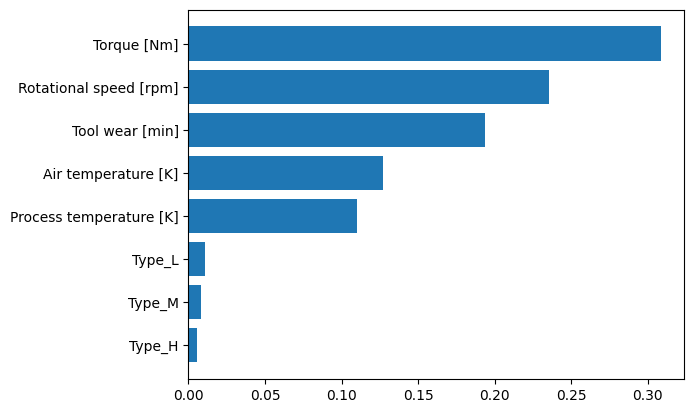

In [14]:
# Get the feature importance values for Random Forest
df_feat_imp = pd.DataFrame()
df_feat_imp["Feature"] = clf_rf.feature_names_in_
df_feat_imp["Importance"] = clf_rf.feature_importances_
df_feat_imp = df_feat_imp.sort_values(by = "Importance", ascending = True)

# Plot a bar chart for the importances
plt.barh(y = df_feat_imp["Feature"], width = df_feat_imp["Importance"])

It can be seen that **Torque [Nm]** and **Rotational speed [rpm]** have the **highest contribution** towards the model in predicting whether the records are failure or not. This actually aligned with the insights obtained from the data exploration in the previous notebook, where higher number of failures are observed at certain value ranges. 

------

### 2c. Gradient Boosting Classifier

First, a simple model is created, and the training set of data is fitted into the model.  
- Default model parameters are used tentatively, as tuning will be performed later.  

After that, the fitted model is used to perform prediction on the test set of data, and then the accuracy is evaluated by comparing the predicted result with the actual result.  

In [15]:
# Create and fit the model. 
clf_gb = GradientBoostingClassifier(n_estimators = 100)
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [16]:
# Perform prediction on the test data by using the trained model. 
y_pred = clf_gb.predict(X_test)

# Check accuracy score & confusion matrix by comparing the predicted result with the actual result. 
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
display(pd.crosstab(y_test, y_pred))

Accuracy Score: 0.98275


col_0,0,1
Target,,
0,3857,20
1,49,74


The accuracy obtained from the basic Gradient Boosting model is at ~98.3%, which is similar to the Random Forest Classifier before. 

Next, **Cross Validation (CV)** is performed, which takes in the full sets of input & output variables (before splitting into training & test sets), creating different combinations of training & test set splits, and then performing model training & evaluation on each of them.  
This is done to avoid overfitting the model just by using one set of training & test data. 

In [17]:
# Cross validation
cv = ShuffleSplit(n_splits = 10, test_size = 0.4, random_state = 0)
list_cv_score = cross_val_score(clf_gb, X, y, cv=cv)
print("List of scores from cross validation: " + str(list_cv_score))
print("Average score: " + str(sum(list_cv_score)/len(list_cv_score)))

List of scores from cross validation: [0.98275 0.982   0.98375 0.984   0.98025 0.9825  0.98175 0.986   0.98125
 0.98525]
Average score: 0.98295


The average accuracy score obtained from the Cross Validation is also close to 98.3%. 

Then, **Parameter Tuning** is done by using the **Grid Search** algorithm.  
Here, a list of values for selected parameter(s) are defined, and then the model training & evaluation will be performed on each combination to find out the combination that works the best. 

In [18]:
# Grid Search / Parameter tuning
param_grid = [
    {
        "n_estimators": [50, 100, 150, 200], 
        "max_depth": [2, 3, 4], 
        "learning_rate": [0.05, 0.1, 0.2]
    }
]
clf_gb_gs = GridSearchCV(clf_gb, param_grid, cv = cv, scoring = "accuracy", verbose = 1)
clf_gb_gs.fit(X_train, y_train)

print("Best Parameter: " + str(clf_gb_gs.best_params_))
print("Score of the Best Parameter: " + str(clf_gb_gs.best_score_))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best Parameter: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Score of the Best Parameter: 0.9810833333333333


In [19]:
# Perform prediction on the test data by using the trained Grid Search model. 
y_pred = clf_gb_gs.predict(X_test)

# Check accuracy score & confusion matrix by comparing the predicted result with the actual result. 
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
display(pd.crosstab(y_test, y_pred))

Accuracy Score: 0.98325


col_0,0,1
Target,,
0,3854,23
1,44,79


Although here more combinations of parameters are defined, the final accuracy obtained is still similar, which is at ~98.3%. 

Some of the models have the **feature importance** attribute, which is able to provide information on the percentage of **contribution of each feature** (input variable) towards the model. 

<BarContainer object of 8 artists>

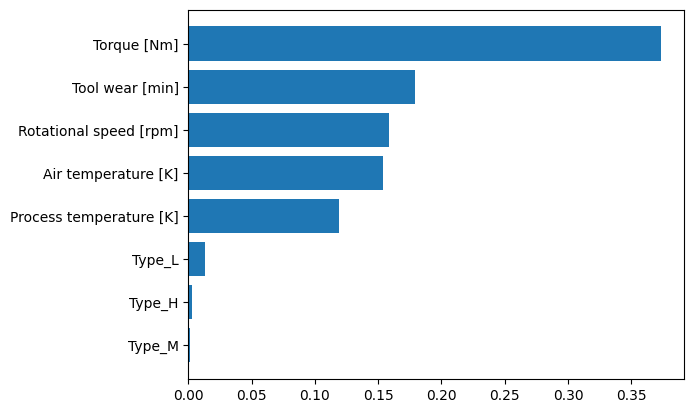

In [20]:
# Get the feature importance values for Random Forest
df_feat_imp = pd.DataFrame()
df_feat_imp["Feature"] = clf_gb.feature_names_in_
df_feat_imp["Importance"] = clf_gb.feature_importances_
df_feat_imp = df_feat_imp.sort_values(by = "Importance", ascending = True)

# Plot a bar chart for the importances
plt.barh(y = df_feat_imp["Feature"], width = df_feat_imp["Importance"])

It can be seen that **Torque [Nm]** and **Rotational speed [rpm]** have the **highest contribution** towards the model in predicting whether the records are failure or not. This actually aligned with the insights obtained from the data exploration in the previous notebook, where higher number of failures are observed at certain value ranges. 

------

### 2d. Saving Models into .joblib files. 

After getting a model that has a satisfying performance, **the model can be saved into a .joblib** file.  
By doing this, the model can be imported and directly put into use in future, without the need to re-train it from scratch.  

One thing to note is that, when fitting data into the model in future, the input variables will need to be in the same sequence as the one used during its training process. Although some models may come with the information of the input variable sequence, it is definitely safer to **save the input variable sequence** into a separate text file for reference. 

In [21]:
# Saving the Random Forest model and the training set column sequence into .joblib file. 
joblib.dump(clf_rf, "clf_rf.joblib")
joblib.dump(X_train.columns, "clf_rf_col_seq.txt")

['clf_rf_col_seq.txt']

With the dump function above, the files are successfully saved into the local folder.  
To import the files in future, the load function can be used as follows. 

In [22]:
clf_rf = joblib.load('clf_rf.joblib') 
clf_rf_col_seq = joblib.load('clf_rf_col_seq.txt') 

------

To summarize, in this notebook, both **Random Forest Classifier** and **Gradient Boosting Classifier** managed to achieve an **accuracy of around 98%**.  
In the next notebook, **deep learning algorithm** will be used to perform the same classification task in an attempt to get a better accuracy. 